# Similarity analysis with influence functions (Fig. 8)

The aim of this notebook is to reproduce the Fig. 8 from the paper 'Unsupervised machine learning of topological phase transitions from experimental data' by N. Kaming, A. Dawid, K. Kottmann, K. Sengstock, M. Lewenstein, A. Dauphin, and C. Weitenberg as well as give a possibility of analyzing other test points than chosen for the mentioned figure.

## Labelling the data accordingly to boundaries found via anomaly detection scheme (section III E)
We have:
- a file 'boundaries.npz' in folder 'data'
- the post-processed experimental data gathered across the full range of frequencies and shaking phases, 'phase_diagram_56_rephased_final.h5' in folder 'data'

We will:
- label the dataset accordingly to the anomaly-detected phases
- generate the training, validation, and test sets

In [1]:
import numpy as np
import h5py
from lib.utility_general import keys, is_equal

SAVE = False

## Load experimental data with the fixed micromotion phase and the boundaries from the anomaly detection
data = h5py.File('./data/phase_diagram_rephased.h5', 'r')
boundaries = np.load('./influence/data_and_masks/boundaries.npz', allow_pickle=True)["boundaries"].item()

print(keys(data['parameter']))

# Extract chosen properties from the h5 file
images = np.array(data['images'])
freq = np.array(data['parameter/freq']) # from 5.1 to 7.8 kHz, every 0.1
phase = np.array(data['parameter/phase']) # from -180 to 180, every 5

## Choose datasets' sizes
dataset_size = images.shape[0]
training_size = 8000
validation_size = 2000
testing_size = 436

## Generate and save labels according to the boundaries from anomaly detection scheme

# Training 1 and 2: three labels
(phases1, freqs1, dy1) = boundaries["0"][0]
(phases2, freqs2, dy2) = boundaries["1"][0]

labels = np.array([])
# Training 1 + 2: lower bound from 1, upper bound from 2
for i in np.arange(images.shape[0]):

    current_frequency = freq[i]
    current_phase = phase[i]

    for phase_index in np.arange(len(phases1)):
        if is_equal(current_phase, phases1[phase_index], 0.01):
            lower_bound = freqs1[phase_index]
        if is_equal(current_phase, phases2[phase_index], 0.01):
            upper_bound = freqs2[phase_index]

    if (current_frequency < lower_bound):
        label = 0
    elif (current_frequency < upper_bound):
        label = 1
    else:
        label = 2
    
    labels = np.append(labels, label)
    
    # For inner peace
    """if (i == 0 or i == 6 or i == 15 or i == 1000 or i == 2000 or i == 3000):
        print("Frequency: ", current_frequency)
        print("Phase: ", current_phase)
        print("Label is: ", label)"""

if SAVE is True:
    np.save('influence/data_and_masks/phase_diagram_anomalydetected_labels.npy', labels.astype(int))

## Create the test, validation, and training sets

# Fix the random seed, if you want to get the same datasets as in the paper
np.random.seed(0)

# Choose test points
test_indices = np.random.choice(dataset_size, testing_size, replace=False).astype(int)
if SAVE is True:
    np.save('influence/data_and_masks/phase_diagram_test_mask.npy', test_indices)

# Training and validation masks
indices = np.arange(dataset_size)
mask = np.delete(indices, test_indices).astype(int)
np.random.shuffle(mask)
validation_mask = mask[:validation_size]
training_mask = mask[validation_size:]
print(len(validation_mask))
print(len(training_mask))
if SAVE is True:
    np.save('influence/data_and_masks/phase_diagram_training_mask.npy', training_mask.astype(int))
    np.save('influence/data_and_masks/phase_diagram_validation_mask.npy', validation_mask.astype(int))

# Means and std deviations for normalization
mean = np.mean(images[training_mask.astype(int)])
std = np.std(images[training_mask.astype(int)])
print("Mean: ", mean)
print("Standard deviation: ", std)

# Sanity check for the normalization
training_images = images[training_mask.astype(int)]
training_images = (training_images - mean) / std
print("After normalization:")
print("Mean: ", np.mean(training_images))
print("Standard deviation: ", np.std(training_images))

['amp', 'freq', 'hold', 'id', 'micromotion_phase', 'phase']
2000
8000
Mean:  0.47376012469840956
Standard deviation:  0.16998128006793728
After normalization:
Mean:  1.5735258900850586e-16
Standard deviation:  1.0000000000000013


## Training the model
We have:
- a prepared training and validation sets which we can load with Downloader from data_loader.py
- a proposed architecture of 2D CNN in architectures.py

We will:
- train the model (set PUBLISHED_MODEL to False)
OR
- skip this step and use in next steps the published and trained model 'published_model_rephased_anomaly_detected_phase_diagram' (set PUBLISHED_MODEL to True)

In [2]:
import torch
import torch.nn as nn
from torch.nn import Sequential, CrossEntropyLoss
import torch.optim as optim

from matplotlib import pyplot as plt

from lib.data import Downloader
from lib.CNN_for_IF import CNN2D

folder_model = 'networks/influence'
folder_influence = 'influence'

PUBLISHED_MODEL = True # do you want to use a published model?

if PUBLISHED_MODEL is True:
    folder_influence = 'influence/published_influence_similarity_analysis'
    model_name = 'published_model_rephased_anomaly_detected_phase_diagram'
    λ_published = 0.05
else:
    model_name = 'experimental_model_rephased_anomaly_detected_phase_diagram'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Hyper-parameters
input_size = 56*56 # original: 151*151 
num_classes = 3   # three phases from anomaly detection scheme

cuda:0


Data loaded.
Model built.
Number of parameters of the net:  1741
Epoch [1/125], Train loss: 1.1257
Accuracy of the model on the 2000 validation images: 26.8 %
Epoch [1/125], Validation loss: 1.1211
Epoch [2/125], Train loss: 1.1144
Accuracy of the model on the 2000 validation images: 24.25 %
Epoch [2/125], Validation loss: 1.1090
Epoch [3/125], Train loss: 1.1034
Accuracy of the model on the 2000 validation images: 25.6 %
Epoch [3/125], Validation loss: 1.0992
Epoch [4/125], Train loss: 1.0952
Accuracy of the model on the 2000 validation images: 26.75 %
Epoch [4/125], Validation loss: 1.0925
Epoch [5/125], Train loss: 1.0893
Accuracy of the model on the 2000 validation images: 28.25 %
Epoch [5/125], Validation loss: 1.0857
Epoch [6/125], Train loss: 1.0808
Accuracy of the model on the 2000 validation images: 46.6 %
Epoch [6/125], Validation loss: 1.0747
Epoch [7/125], Train loss: 1.0671
Accuracy of the model on the 2000 validation images: 59.55 %
Epoch [7/125], Validation loss: 1.0558


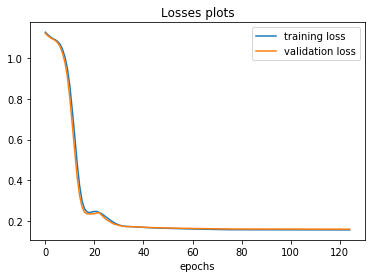

In [7]:
# To reproduce the training from the paper
np.random.seed(0)
torch.manual_seed(17)
λ = 0.05 # Regularization
learning_rate = 0.01
num_epochs = 125
batch_size = 4000

# Loading experimental data
dataset = Downloader('phase_diagram_rephased', batch_size)
train_loader = dataset.train_loader()
validation_loader = dataset.validation_loader(batch_size=2000)
training_set_size = dataset.training_samples_no()
print("Data loaded.")

model = CNN2D(no_classes=3)
model.to(device)
print("Model built.")

print("Number of parameters of the net: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
# 1741 - 3class, 1540 - 2class

if PUBLISHED_MODEL is False:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
    #optimizer = torch.optim.Adam(model.parameters()) # lr = 0.001
    #scheduler = None
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 125], gamma=0.1)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2)

    # Train the model
    hold_loss=[]
    hold_val_loss = []
    for epoch in range(num_epochs):

        for phase in ['train', 'val']:

            if phase == 'train':
                model.train()  # Set model to training mode

                for i, (eigenvectors, labels) in enumerate(train_loader):
                    # Reshape eigenvectors to (batch_size, # of RGB channels, size, size)
                    eigenvectors = eigenvectors.reshape(-1, 1, 56, 56)

                    eigenvectors, labels = eigenvectors.to(device), labels.to(device)

                    # Forward pass
                    outputs = model(eigenvectors)
                    #print(outputs.shape)
                    loss = criterion(outputs, labels)
        
                    # We manually add L2 regularization
                    if λ != 0:
                        l2_reg = 0.0
                        for param in model.parameters():
                            l2_reg += torch.norm(param)**2
                        loss += 1/training_set_size * λ/2 * l2_reg

                    # Backward and optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
                print ('Epoch [{}/{}], Train loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

                hold_loss.append(loss.item())

            if phase == 'val':
                model.eval()  # Set model to evaluating mode

                with torch.no_grad():
                    correct = 0
                    for eigenvectors, labels in validation_loader:
                        eigenvectors = eigenvectors.reshape(-1, 1, 56, 56)

                        eigenvectors, labels = eigenvectors.to(device), labels.to(device)

                        outputs = model(eigenvectors)
                        _, predicted = torch.max(outputs.data, 1)  # classification
                        #print ("Prediction is: ", predicted)  # classification
                        val_loss = criterion(outputs, labels)
                        # We manually add L2 regularization
                        if λ != 0:
                            l2_reg = 0.0
                            for param in model.parameters():
                                l2_reg += torch.norm(param)**2
                            val_loss += 1/training_set_size * λ/2 * l2_reg

                        correct = (predicted == labels).sum().item()  # classification

                    hold_val_loss.append(val_loss.item())
                    print("Accuracy of the model on the", len(labels), "validation images:", 100 * correct / len(labels), "%")
            
                print ('Epoch [{}/{}], Validation loss: {:.4f}'.format(epoch+1, num_epochs, val_loss.item()))

                if scheduler is not None:
                    scheduler.step() # here for milestones scheduler
                    #scheduler.step(val_loss) # here for Plateau scheduler

    plt.plot(hold_loss, label="training loss")
    plt.plot(hold_val_loss, label="validation loss")
    plt.xlabel('epochs')
    plt.title("Losses plots")
    plt.legend()
    plt.show()

    # Save the model checkpoint
    torch.save(model.state_dict(), folder_model + '/' + model_name + '.pt')

## Testing the model
We have:
- a prepared test set which we can load with Downloader from data_loader.py
- either the trained model from the previous step OR we chose to use the published model

We will:
- test the model and save all test losses

In [5]:
## Test the model on the testing data and save all test losses (needed for influence functions' calculations)
from lib.utility_general import save_to_file

# Loading CDW data
batch_size = 8000
dataset = Downloader('phase_diagram_rephased', batch_size)
test_loader = dataset.test_loader()
training_set_size = dataset.training_samples_no()

model = CNN2D(no_classes=3)

if PUBLISHED_MODEL is True:
    model_name = 'published_model_anomaly_detected_phase_diagram_rephased'
    λ = λ_published
    
model.load_state_dict(torch.load(folder_model + '/' + model_name + '.pt'))
model.to(device)
model.eval()

criterion = nn.CrossEntropyLoss(reduction='none')

with torch.no_grad():
    correct = 0
    for eigenvectors, labels in test_loader:
        eigenvectors = eigenvectors.reshape(-1, 1, 56, 56)

        eigenvectors, labels = eigenvectors.to(device), labels.to(device)

        outputs = model(eigenvectors)
        _, predicted = torch.max(outputs.data, 1)  # classification
        test_loss = criterion(outputs, labels)
        
        # We manually add L2 regularization
        if λ != 0:
            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param)**2
                test_loss += 1/training_set_size * λ/2 * l2_reg

        correct = (predicted == labels).sum().item()  # classification

        predicted_labels_storage = np.array(predicted.cpu()) # it flattens a tuple of tensors to 1D tensor (and then converts tensor to numpy array)
        predicted_loss_storage = np.array(test_loss.cpu())
        print("Accuracy of the model on the", len(labels), "test images:", 100 * correct / len(labels), "%")

# Save the test losses
save_to_file(np.array(predicted_loss_storage), 'all_test_losses_' + model_name + '.txt', folder_influence)

Accuracy of the model on the 436 test images: 95.64220183486239 %


## Calculating the hessian
We have:
- either the trained model from the previous step OR we chose to use the published model

We will:
- calculate the Hessian of the training loss with respect to the model's parameters
OR
- skip this step and use the calculated Hessian for the published model

In [8]:
## Calculate the hessian (or skip this step if you use the published model)
from lib.influence_function import find_heigenvalues, find_hessian

if PUBLISHED_MODEL is True:
    model_name = 'published_model_anomaly_detected_phase_diagram_rephased'
    final_folder_influence = folder_influence
    λ = λ_published
    hessian = np.load(folder_influence + '\\' + model_name + '_hessian.npy')
    heigenvalues = np.sort(np.linalg.eigvalsh(hessian))
    print("Largest negative eigenvalue of the Hessian of the training loss: ", np.amin(heigenvalues))

else:
    model_name = 'experimental_model_anomaly_detected_phase_diagram_rephased'
    final_folder_influence = folder_influence + '/influence_similarity_analysis'

    criterion = nn.CrossEntropyLoss()
    train_loader = dataset.train_loader()

    # Compute and save Hessian and its eigenvalues
    for i, (eigenvectors, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, # of RGB channels, size, size)
        eigenvectors = eigenvectors.reshape(-1, 1, 56, 56) #(batch_size, 25, 50)

        eigenvectors, labels = eigenvectors.to(device), labels.to(device)

        # Forward pass
        outputs = model(eigenvectors)
        loss = criterion(outputs, labels)

        # We manually add L2 regularization
        if λ != 0:
            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param)**2
            loss += 1/training_set_size * λ/2 * l2_reg

        hessian = find_hessian(loss, model)
        #hessian = torch.autograd.functional.hessian(criterion)
        np.save(final_folder_influence + '\\' + model_name + '_hessian', hessian)
        heigenvalues = np.sort(np.linalg.eigvalsh(hessian))
        print("Largest negative eigenvalue of the Hessian of the training loss: ", np.amin(heigenvalues))
        save_to_file(heigenvalues, model_name + '_heigenvalues.txt', final_folder_influence)

Largest negative eigenvalue of the Hessian of the training loss:  -0.12297572


## Calculating the influence functions
We have:
- either the trained model from the previous step OR we chose to use the published model
- the Hessian of the training loss w.r.t. the model's parameters
- test losses for all test points

We will:
- calculate the influence functions between the chosen test points and the whole training set
OR
- skip this step and use the calculated influence functions for the published model

In [10]:
## Calculate influence functions for chosen test points and all training points
from lib.utility_general import save_to_file, flatten_grad
from lib.influence_function import grad_z, find_heigenvalues, find_hessian
from tqdm.notebook import trange # for the progress bar

damping = 0.2 # needs to be a little larger than the absolute value of the largest negative eigenvalue of the hessian
model_params_no = 1741 # 1540 for 2 classes, 1741 for 3 classes

model = CNN2D(no_classes=3)

if PUBLISHED_MODEL is True:
    model_name = 'published_model_anomaly_detected_phase_diagram_rephased'
    final_folder_influence = folder_influence + '/published_influence_similarity_analysis'
    λ = λ_published
else:
    model_name = 'experimenal_model_anomaly_detected_phase_diagram_rephased'
    final_folder_influence = folder_influence + '/influence_similarity_analysis'

model.load_state_dict(torch.load(folder_model + '/' + model_name + '.pt'))

for _, (eigenvectors, labels) in enumerate(train_loader):
    # Reshape images to (batch_size, # of RGB channels, size, size)
    eigenvectors = eigenvectors.reshape(-1, 1, 56, 56)
    
    # Forward pass
    hessian_outputs = model(eigenvectors)
    hessian_loss = criterion(hessian_outputs, labels)

    # We manually add L2 regularization
    if λ != 0:
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param)**2
        hessian_loss += 1/training_set_size * λ/2 * l2_reg

    hessian = np.load(final_folder_influence + '\\' + model_name + '_hessian.npy')
    damped_hessian = hessian + np.identity(model_params_no)*damping
    #print(np.linalg.eigvalsh(damped_hessian))
    inv_hessian = torch.inverse(torch.from_numpy(damped_hessian)).float()
    print("The full Hessian got inverted.")
    np.save(final_folder_influence + '\\' + model_name + '_invhessian.npy', inv_hessian)
    #inv_hessian = torch.from_numpy(np.load(folder_influence + '/' + model_name + '_invhessian.npy')).float()

    # Choose test points, e.g.:
    chosen_test_examples = np.array([5,46,7]) #np.arange(50)

    for _, (test_eigenvectors, test_labels) in enumerate(test_loader):
        
        test_eigenvectors = test_eigenvectors.reshape(-1, 1, 56, 56) #(-1, 25, 50)
            
        for i in trange(len(chosen_test_examples), desc='calculating influence for chosen test examples'):

            test_example = chosen_test_examples[i]
            print("Looking at the test example no. ", test_example, " right now.")

            grad_test_loss = grad_z(test_eigenvectors[test_example:test_example+1], test_labels[test_example:test_example+1], model, criterion, training_set_size, λ=λ)
            grad_test_loss = flatten_grad(grad_test_loss)
            s_test = torch.mv(inv_hessian, grad_test_loss)

            print("s_test for the test example no. ", test_example, " will be multiplied by gradients right now.")

            influence = []
            for train_example in trange(training_set_size, desc='calculating influence for all training points'):

                grad_train_loss = grad_z(eigenvectors[train_example:train_example+1], labels[train_example:train_example+1], model, criterion, training_set_size, λ=λ)
                grad_train_loss = flatten_grad(grad_train_loss)

                influence_function = - torch.dot(s_test, grad_train_loss) * (- 1 / training_set_size)
                influence.append(influence_function.item())

            save_to_file(influence, 'exact_influence_test' + str(test_example) + '.txt', final_folder_influence)
            print("Done.")

The full Hessian got inverted.


Looking at the test example no.  5  right now.
s_test for the test example no.  5  will be multiplied by gradients right now.



Done.
Looking at the test example no.  46  right now.
s_test for the test example no.  46  will be multiplied by gradients right now.



Done.
Looking at the test example no.  7  right now.
s_test for the test example no.  7  will be multiplied by gradients right now.



Done.



## Final plot
We have:
- either the trained model from the previous step OR we chose to use the published model
- influence functions for the chosen test points and all training points

We will:
- reproduce the fig. 8 from the paper with results produced within this notebook (set PUBLISHED_RESULTS to False) OR
- reproduce the fig. 8 from the paper with published results (set PUBLISHED_RESULTS to True)

You can play with chosen three test points. The ones that are in the paper have indices 5, 46, and 7.

5.6
6.6
7.6


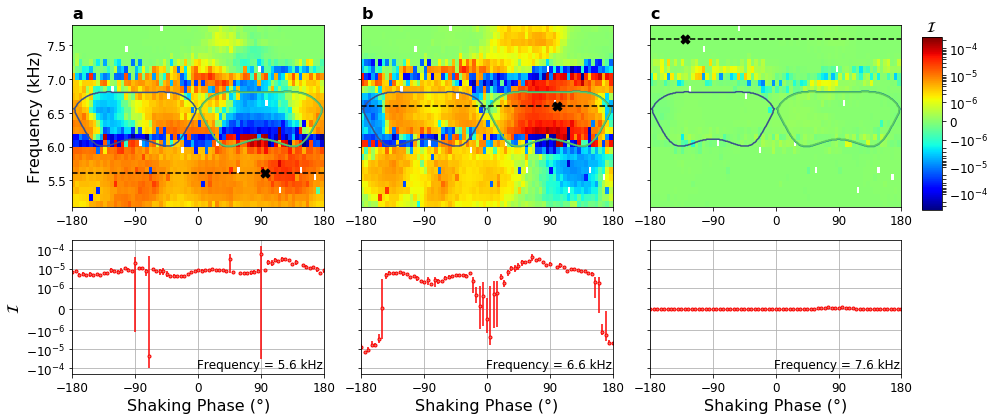

In [14]:
from lib.utility_plots import make_similarity_analysis_plot

PUBLISHED_RESULTS = True

if PUBLISHED_RESULTS is True:
    folder_influence = 'influence/published_influence_similarity_analysis'
    chosen_3_test_points = np.array([5,46,7])
else:
    folder_influence = 'influence/influence_similarity_analysis'
    chosen_3_test_points = np.array([5,46,7])

make_similarity_analysis_plot(chosen_3_test_points, folder_influence, folder_model)